In [173]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch

In [174]:
skill = 5

alpha = 0.5#Consumption
beta = 0.5e-5 #Savings
gamma = 1e-2 #Inventory
risk = 0.8

no_households = 100
no_firms = 10



house_in = 4+no_firms
house_hidd = 32
house_out = 3

firm_in = 4
firm_hidd = 32
firm_out = 4



interest_rate = 0.05

#Variables whihc help in training 
MAX_REWARD = 100

INITAL_MONEY = 1000

#To assist training
MIN_PRICE = 1
MIN_WAGE = 1
MIN_CONSUMPTION = 1

In [175]:
#A simple neural network architecture
class genetic_network(nn.Module):
    def __init__(self,inp,hidd,out):
        super().__init__()
        self.architecture= nn.Sequential(
        nn.Linear(inp,hidd),
        nn.ReLU(),
        nn.Linear(hidd,out),
        nn.ReLU(),
    
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1.0, b=1.0)   
    def forward(self,x):
        logits = self.architecture(x)
        return logits
    
#A function to get the weights of the nn
def gene(network):
    flat_params = torch.cat([p.view(-1) for p in network.parameters()])
    return flat_params

def set_gene(gene,inp,hidd,out):
    model = genetic_network(inp,hidd,out)
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        new_values = gene[pointer:pointer+numel].view_as(param)
        with torch.no_grad():
            param.copy_(new_values)
        pointer+=numel
    return model

In [176]:
#Recombination strategies
def recombine_weighted(gene_a,gene_b,alpha):
    return (gene_a*alpha + (1-alpha)*gene_b,gene_b*alpha + (1-alpha)*gene_a)

#def 1 point crossover
def crossover(gene_a,gene_b):
    m = int(len(gene_a) / 2)
    child1 = torch.cat([gene_a[:m], gene_b[m:]], dim=0)
    child2 = torch.cat([gene_b[:m], gene_a[m:]], dim=0)
    return child1, child2
#Uniform crossover
def uniform_crossover(gene_a,gene_b):
    mask = torch.rand_like(gene_a,dtype=torch.float)<0.5
    child1 = torch.where(mask,gene_a,gene_b)
    child2 = torch.where(mask,gene_b,gene_a)
    return child1,child2 

#Random reset mutate
def random_reset(gene_a,prob):
    gene_a = gene_a.clone()
    for idx in range(gene_a.numel()):
        if(random.random()<prob):
            gene_a.view(-1)[idx] = random.uniform(-0.1,0.1)
    return gene_a

In [177]:
class Household:
    def __init__(self):
        self.savings = INITAL_MONEY
        input_len = house_in # savings, interest rate, tax rate, tax credit, prices,skill
        output_len = house_out #Min acceptable price, Amount to be bought, Minimum work wage
        self.reward = 0
        self.consumption = 0
        self.mind = genetic_network(input_len,house_hidd,output_len)
        
    def act(self,interest_rate,tax_rate_house,tax_credits,firms):
        #Generate interest
        self.savings = (1+interest_rate)*self.savings

        prices = torch.tensor([firm.price for firm in firms],dtype=torch.float32)
        input_data = torch.tensor(
            [self.savings, interest_rate, tax_rate_house, tax_credits],
            dtype=torch.float32
        )
        input_data = torch.cat([input_data, prices])
        self.output = self.mind(input_data)
        self.output = torch.clamp(self.output, min=0)

        self.max_price = self.output[0].item()
        self.amt_to_buy = self.output[1].item() + MIN_CONSUMPTION
        self.min_wage = self.output[2].item() + MIN_WAGE
        # print(self.output) 
        return self.output #(Max acceptable price, How much they wish to buy, Minimum wage)
       
    def comp_reward(self):
       #Simplified reward
       self.reward += alpha*pow(self.consumption,1-risk)/(1-risk) + beta * self.savings
       self.consumption = 0 #Reset it to 0
       self.reward = max(min(self.reward,MAX_REWARD),-MAX_REWARD)


In [178]:
#Firms
class Firm:
    def __init__(self):
        self.savings = INITAL_MONEY
        self.price = 0
        self.goods_inventory = 0
        input_len = firm_in # savings, interest rate, firm tax rate, firm tax credit
        output_len = firm_out #Min acceptable price, Maximum work wage, Max Employees (Each employee produces a fixed number of pdts)
        self.mind = genetic_network(input_len,firm_hidd,output_len)
        self.reward = 0
        
    def act(self,interest_rate,tax_rate_firm,tax_credits):
        self.savings = (1+interest_rate)*self.savings
        input_data = torch.tensor(
            [self.savings, interest_rate, tax_rate_firm, tax_credits],
            dtype=torch.float32
        )
        input_data = torch.cat([input_data])
        self.output = self.mind(input_data)
        self.output = torch.clamp(self.output, min=0)
        
        self.min_price = self.output[0].item() + MIN_PRICE
        self.max_wage = self.output[1].item()
        self.max_employees = self.output[2].item()
        return self.output
    
    def comp_reward(self):
       #Simplified reward
       self.reward += beta*self.savings - gamma * self.goods_inventory
       self.reward = max(min(self.reward,MAX_REWARD),-MAX_REWARD)
       

In [179]:
class gov_policy_network(nn.Module):
    def __init__(self,in_dims,out_dims):
        super().__init__()
        self.architecture= nn.Sequential(
            nn.Linear(in_dims,32),
            nn.Sigmoid(),
            nn.Linear(32,out_dims), # house tax mean,house tax std , firm t m, firm t std
            nn.Sigmoid()
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1.0, b=1.0)   

    def forward(self,x):
        logits = self.architecture(x)
        return logits

class gov_value_network(nn.Module):
    def __init__(self,in_dims,out_dims):
        super().__init__()
        self.architecture= nn.Sequential(
            nn.Linear(in_dims,16),
            nn.ReLU(),
            nn.Linear(16,out_dims), # house tax mean,house tax std , firm t m, firm t std
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, a=-1.0, b=1.0)   

    def forward(self,x):
        logits = self.architecture(x)
        return logits


In [180]:
import torch.distributions as dist
xi = 0
class Government:
    def __init__(self, tax_rate_house, tax_rate_firm, tax_credits):
        self.tax_rate_house = tax_rate_house
        self.tax_rate_firm = tax_rate_firm
        self.tax_credits = tax_credits
        self.tax_collected_house = INITAL_MONEY * tax_rate_house * no_households
        self.tax_collected_firm = INITAL_MONEY * tax_rate_firm * no_households
        self.policyNet = gov_policy_network(5,4)
        self.valueNet = gov_value_network(4,1)
        self.mean_trh = 0
        self.std_trh = 0
        self.mean_trf = 0
        self.std_trf = 0

        

    # make sure the act() doesn't output out-of-domain values!!!!!
    def act(self,houses):
        # inputs: tax_rate_house, tax_rate_firm, tax_collected_house, tax_collected_firm, tax_credits
        p_max_utility = max([house.reward for house in houses])
        p_min_utility = min([house.reward for house in houses])
        
        input = torch.tensor([self.tax_rate_house,
                              self.tax_rate_firm,
                              self.tax_collected_firm + self.tax_collected_house,
                              p_max_utility,
                              p_min_utility],dtype=torch.float32)
        
       

        self.mean_trh , self.std_trh , self.mean_trf , self.std_trf = self.policyNet(input).tolist()
        self.std_trh , self.std_trf = min(max(0.01, self.std_trh),0.2) , min(max(0.01, self.std_trf),0.2)
        
        self.tax_rate_house = np.clip(np.random.normal(loc=self.mean_trh, scale=self.std_trh, size=1)[0], 0, 1)
        self.tax_rate_firm = np.clip(np.random.normal(loc=self.mean_trf, scale=self.std_trf, size=1)[0], 0, 1)

        self.credit_distrib = [1 / len(houses) for _ in houses]  # equal distribution for now

    def step(self,houses,firms):
        self.tax_collected_house = sum([self.tax_rate_house * house.savings for house in houses])
        self.tax_collected_firm = sum([self.tax_rate_firm * max(0, firm.savings) for firm in firms])

        for h in houses:
            h.savings = h.savings * (1 - self.tax_rate_house)

        for f in firms:
            f.savings = f.savings * (1 - self.tax_rate_firm)

        self.tax_credits = [my_credit_frac * xi * (self.tax_collected_house + self.tax_collected_firm) for my_credit_frac in self.credit_distrib]

    def comp_reward(self,houses):

        theta = 0.5 # interpolates between wellfare reward and credit reward

        # prioritarian social wellfare function
        def wellfare_fn(rewards):
            # make sure non-negative
            if (mini := np.min(rewards)) < 0:
                rewards = rewards - mini

            exponent = 0.5
            transformed = np.power(rewards, exponent)
            total = np.sum(transformed)

            if total == 0:
                return np.ones_like(rewards) / len(rewards)

            return transformed / total

        wellfare_weights = wellfare_fn([house.reward for house in houses])

        tot_wellfare = sum([weight * house.reward for weight, house in zip(wellfare_weights, houses)])
        tot_credit = sum([weight * credit for weight, credit in zip(wellfare_weights, self.tax_credits)])

        self.reward = theta * tot_wellfare + (1 - theta) * tot_credit

        # ==================== #
        self.tax_collected_house = 0
        self.tax_collected_firm = 0
        # ==================== #

In [181]:
#Generate Households
#Formula for generating next generation
def generate_houses(group):
    group = sorted(group,key=lambda b:b.reward,reverse=True)
    new_group = []
    #Add the top 30%performers to the next group
    for i in range(0,int(0.3*len(group))):
        f = Household()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = (min(f.reward for f in group)-0.1)
        chosen_one = random.choices(group, weights=[f.reward-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.reward-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        mutated3 = uniform_crossover(gene_a,gene_b)
        
        f = Household()
        f.mind = set_gene(random_reset(mutated[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)
        
        f = Household()
        f.mind = set_gene(random_reset(mutated2[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated2[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)

        f = Household()
        f.mind = set_gene(random_reset(mutated3[0],0.01),house_in,house_hidd,house_out)
        new_group.append(f) 
        f2 = Household()
        f2.mind = set_gene(random_reset(mutated3[1],0.01),house_in,house_hidd,house_out)
        new_group.append(f2)
    return new_group[:len(group)]

#RESET HOUSES
def reset_houses(group):
    new_group = []
    for i in range(0,int(len(group))):
        f = Household()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)
    return new_group


In [182]:
#Generate firms
def generate_firms(group):
    group = sorted(group,key=lambda b:b.reward,reverse=True)
    new_group = []
    #Add the top 30%performers to the next group
    for i in range(0,int(0.3*len(group))):
        f = Firm()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)

    #Add some recombinations
    while len(new_group)<len(group):
        min_score = (min(f.reward for f in group)-0.1)
        chosen_one = random.choices(group, weights=[f.reward-min_score for f in group], k=1)[0]
        remaining = [f for f in group if f != chosen_one]
        remaining_weights = [f.reward-min_score for f in remaining]
        chosen_two = random.choices(remaining, weights=remaining_weights, k=1)[0]
        gene_a = gene(chosen_one.mind)
        gene_b = gene(chosen_two.mind)
        mutated = crossover(gene_a,gene_b)
        mutated2 = recombine_weighted(gene_a,gene_b,0.4)
        mutated3 = uniform_crossover(gene_a,gene_b)
        
        f = Firm()
        f.mind = set_gene(random_reset(mutated[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)
        
        f = Firm()
        f.mind = set_gene(random_reset(mutated2[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated2[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)

        f = Firm()
        f.mind = set_gene(random_reset(mutated3[0],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f) 
        f2 = Firm()
        f2.mind = set_gene(random_reset(mutated3[1],0.01),firm_in,firm_hidd,firm_out)
        new_group.append(f2)
    return new_group[:len(group)]

#RESET FIRMS
def reset_firms(group):
    new_group = []
    for i in range(0,int(len(group))):
        f = Firm()
        f.mind = group[i].mind #Keep the same weights
        new_group.append(f)
    return new_group

In [183]:
def reset_gov(gov,len_houses):
    gov_new = Government(0.1,0.1,[1 for house in range(len_houses)])
    gov_new.policyNet = gov.policyNet
    gov_new.valueNet = gov.valueNet
    return gov_new

In [184]:
# A function to monitor flow of goods and services
def work_trade(households,firms,gov):
    gov.act(households)
    
    #All households and firms act
    for f in firms:
        f.act(interest_rate = interest_rate,tax_rate_firm = gov.tax_rate_firm ,tax_credits = 0) # i do not believe there are tax credits for firms

    for i,h in enumerate(households):
        h.act(interest_rate = interest_rate,tax_rate_house = gov.tax_rate_house , tax_credits = gov.tax_credits[i] , firms = firms)


    #Work loop
    for h in households:
        for f in firms:
            if(h.min_wage <= f.max_wage and f.max_employees >0):
                h.savings += f.max_wage
                f.savings -= f.max_wage
                f.max_employees -=1
                f.goods_inventory += skill
                break

    #Now for buying
    for h in households:
        
        for f in firms:
            if(h.amt_to_buy <= 0):
                break
            if(f.min_price<=h.max_price and h.amt_to_buy>0 and f.goods_inventory>0):
                purchase = max(min(h.amt_to_buy,f.goods_inventory),0)
                money = purchase*f.min_price

                f.goods_inventory -= purchase
                f.savings += money

                h.consumption += purchase
                h.savings -= money
                h.amt_to_buy -= purchase

    
    gov.step(households,firms)
   

In [185]:
import torch.distributions as dist

discount_factor = 0.7
e = 0.2

def get_advantage(gov : Government,gov_utilities,min_savings_houses,max_savings_houses,min_savings_firms,max_savings_firms,i):

    value = gov.valueNet(torch.tensor([min_savings_houses,max_savings_houses,min_savings_firms,max_savings_firms],dtype=torch.float32))
    for j in range(i,i + 10):
        value -= gov_utilities[j] * ((discount_factor) ** (j - i))
    value = value * -1

    return value


def TD_PPO(gov ,firm_tax_rates ,house_tax_rates ,collected_taxes ,min_utility ,max_utility ,tax_details ,gov_utilities ,min_savings_houses ,max_savings_houses ,min_savings_firms ,max_savings_firms):
  
    optimizer = torch.optim.Adam(gov.policyNet.parameters(), lr=3e-6)
    losses = []

    optimizer_valuenet = torch.optim.Adam(gov.valueNet.parameters(), lr=1e-5)
    losses_valuenet = []

    for i in range(1,len(min_utility) - 9):
        # value is clipped rn at 10 steps
        adv = get_advantage(gov,gov_utilities,min_savings_houses[i],max_savings_houses[i],min_savings_firms[i],max_savings_firms[i],i)

        losses_valuenet.append(torch.square(adv))
        adv = adv.detach()

        input = torch.tensor([house_tax_rates[i-1],
                              firm_tax_rates[i-1],
                              collected_taxes[i-1],
                              max_utility[i-1],
                              min_utility[i-1]],dtype=torch.float32)
        print(input)
        
        mean_trh , std_trh , mean_trf , std_trf = gov.policyNet(input)
        std_trh = torch.clamp(std_trh, min=0.01,max = 0.2)
        std_trf = torch.clamp(std_trf, min=0.01,max = 0.2)
    
        dist_house = dist.normal.Normal(mean_trh,std_trh)
        dist_firm = dist.normal.Normal(mean_trf,std_trf)

        prob_house = dist_house.log_prob(torch.tensor([house_tax_rates[i]]))
        prob_firm = dist_firm.log_prob(torch.tensor([firm_tax_rates[i]]))

        prob_current = prob_house + prob_firm

        old_dist_house = dist.normal.Normal(tax_details[i][0],tax_details[i][1])
        old_dist_firm = dist.normal.Normal(tax_details[i][2],tax_details[i][3])

        old_prob_house = old_dist_house.log_prob(torch.tensor([house_tax_rates[i]]))
        old_prob_firm = old_dist_firm.log_prob(torch.tensor([firm_tax_rates[i]]))

        prob_old = old_prob_house + old_prob_firm
        prob_old = prob_old.detach()

        ratio = torch.exp(prob_current - prob_old)

        surr1 = ratio * adv
        surr2 = torch.clamp(ratio, 1 - e, 1 + e) * adv

        loss = -torch.min(surr1, surr2)

        losses.append(loss)
    
    # ============= xxx =======
    # Policy Network Training
    # === xxx ===

    total_loss = torch.stack(losses).mean()  # Average loss across all timesteps

    optimizer.zero_grad()           # Clear gradients
    total_loss.backward()           # Compute gradients
    torch.nn.utils.clip_grad_norm_(gov.policyNet.parameters(), max_norm=0.5)  # Gradient clipping
    optimizer.step()                # Update parameters

    # Optional: print training info
    print(f"Total Policy Loss: {total_loss.item():.4f}")

    # ============= xxx =======
    # Value Network Training
    # === xxx ===

    total_valuenet_loss = torch.stack(losses_valuenet).mean()

    optimizer_valuenet.zero_grad()           # Clear gradients
    total_valuenet_loss.backward()           # Compute gradients
    torch.nn.utils.clip_grad_norm_(gov.valueNet.parameters(), max_norm=0.5)  # Gradient clipping
    optimizer_valuenet.step()                # Update parameters

    # Optional: print training info
    print(f"Total Value Net Loss: {total_valuenet_loss.item():.4f}")


In [186]:
house_rewards = []
firm_rewards = []
mean_household_savings = []
mean_firm_savings = []
mean_consumption = []
mean_inventory = []

tax_rates_houses = []
tax_rates_firms = []


#Initialize
households = []
for i in range(0,no_households):
    households.append(Household())

#Firms
firms = []
for i in range(0,no_firms):
    firms.append(Firm())

gov = Government(0.1,0.1,[1 for house in households])

ga_vs_rl = True
cycle  = 5
epochs = 2
ga_epochs = 5
rl_timesteps = 20
rl_epochs = 100
RL_HISTORY_LEN = 50
simulation_steps = 100

epoch_house_reward = []
epoch_firm_reward = []
epoch_gov_reward = []
epoch_housetax = []
epoch_firmtax = []
epoch_housesavings = []
epoch_firmsavings = []

for epoch in range(epochs):
    if ga_vs_rl:
        i = 0
        for e in range(ga_epochs):
            i += 1
            #Firm train cycle
            for t in range(simulation_steps):
                work_trade(households,firms,gov)

            f_r = 0
            h_r = 0
            h_s = 0
            f_s = 0
            m_c = 0
            m_i = 0

            for f in firms:
                f_s += f.savings
                m_i += f.goods_inventory
                f.comp_reward()
                f_r += f.reward

            f_r /= len(firms)
            f_s /= len(firms)
            m_i /= len(firms)

            for h in households:
                m_c += h.consumption
                h_s += h.savings
                h.comp_reward()
                h_r += h.reward        

            h_r /= len(households)
            h_s /= len(households)
            m_c /= len(households)

            gov.comp_reward(households)

            # print(f_r,h_r)
            house_rewards.append(h_r)
            firm_rewards.append(f_r)
            mean_household_savings.append(h_s)
            mean_firm_savings.append(f_s)
            mean_inventory.append(m_i)
            mean_consumption.append(m_c)

            tax_rates_firms.append(gov.tax_rate_firm)
            tax_rates_houses.append(gov.tax_rate_house)

            if(i%(2*cycle) < cycle):
                # print("HOUSEHOLD")
                households = generate_houses(households)
                firms = reset_firms(firms)
                gov = reset_gov(gov,len(households))
            else:
                # print("FIRM")
                firms = generate_firms(firms)
                households = reset_houses(households)
                gov = reset_gov(gov,len(households))
        ga_vs_rl = False
    else:
        for r in range(rl_epochs):
            print(f"RL epoch {r}")

            firms = reset_firms(firms)
            households = reset_houses(households)
            gov = reset_gov(gov,len(households))

            firm_tax_rates = []
            house_tax_rates = []
            collected_taxes = []
            min_utility = []
            max_utility = []
            tax_details = []
            gov_utilities = []
            min_savings_houses = []
            max_savings_houses = []
            min_savings_firms = []
            max_savings_firms = []
            
            for t in range(rl_timesteps):

                work_trade(households,firms,gov)

                for f in firms:
                    f.comp_reward()

                for h in households:
                    h.comp_reward()
        
                gov.comp_reward(households)

                firm_tax_rates.append(gov.tax_rate_firm)
                house_tax_rates.append(gov.tax_collected_house)
                collected_taxes.append(gov.tax_collected_firm + gov.tax_collected_house)
                min_utility.append(min([h.reward for h in households]))
                max_utility.append(max([h.reward for h in households]))
                tax_details.append((gov.mean_trh,gov.std_trh,gov.mean_trf,gov.std_trf))
                gov_utilities.append(gov.reward)
                min_savings_houses.append(min([h.savings for h in households]))
                max_savings_houses.append(max([h.savings for h in households]))
                min_savings_firms.append(min([f.savings for f in firms]))
                max_savings_firms.append(max([f.savings for f in firms]))


            # clip histories

            # if len(firm_tax_rates) > RL_HISTORY_LEN: firm_tax_rates = firm_tax_rates[-RL_HISTORY_LEN:]
            # if len(house_tax_rates) > RL_HISTORY_LEN: house_tax_rates = house_tax_rates[-RL_HISTORY_LEN:]
            # if len(collected_taxes) > RL_HISTORY_LEN: collected_taxes = collected_taxes[-RL_HISTORY_LEN:]
            # if len(min_utility) > RL_HISTORY_LEN: min_utility = min_utility[-RL_HISTORY_LEN:]
            # if len(max_utility) > RL_HISTORY_LEN: max_utility = max_utility[-RL_HISTORY_LEN:]
            # if len(tax_details) > RL_HISTORY_LEN: tax_details = tax_details[-RL_HISTORY_LEN:]
            # if len(gov_utilities) > RL_HISTORY_LEN: gov_utilities = gov_utilities[-RL_HISTORY_LEN:]
            # if len(min_savings_houses) > RL_HISTORY_LEN: min_savings_houses = min_savings_houses[-RL_HISTORY_LEN:]
            # if len(max_savings_houses) > RL_HISTORY_LEN: max_savings_houses = max_savings_houses[-RL_HISTORY_LEN:]
            # if len(min_savings_firms) > RL_HISTORY_LEN: min_savings_firms = min_savings_firms[-RL_HISTORY_LEN:]
            # if len(max_savings_firms) > RL_HISTORY_LEN: max_savings_firms = max_savings_firms[-RL_HISTORY_LEN:]

            
            # Train gov rl
            TD_PPO(gov,
                firm_tax_rates,
                house_tax_rates,
                collected_taxes,
                min_utility,
                max_utility,
                tax_details,
                gov_utilities,
                min_savings_houses,
                max_savings_houses,
                min_savings_firms,
                max_savings_firms,
                )
            
            epoch_house_reward.append(np.mean(np.array([h.reward for h in households])))
            epoch_firm_reward.append(np.mean(np.array([f.reward for f in firms])))
            epoch_gov_reward.append(gov.reward)
            epoch_housetax.append(gov.tax_rate_house)
            epoch_firmtax.append(gov.tax_rate_firm)
            epoch_housesavings.append(np.mean(np.array([h.savings for h in households])))
            epoch_firmsavings.append(np.mean(np.array([f.savings for f in firms])))

            firms = reset_firms(firms)
            households = reset_houses(households)
            gov = reset_gov(gov,len(households))

        ga_vs_rl = True

RL epoch 0
tensor([0.0000e+00, 3.1718e-01, 0.0000e+00, 8.0225e+00, 1.5640e-03])
tensor([0.0000e+00, 2.4058e-01, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 4.0220e-01, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 3.7278e-01, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 2.7524e-01, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 3.0744e-01, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9544e+00, 1.5640e-03])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9544e+00, 1.5640e-03])
Total Policy Loss: 23053712.3782
Total Value Net Loss: 140476418097152.0000
RL epoch 1
tensor([0.0000e+00, 4.0652e-01, 0.0000e+00, 8.0245e+00, 3.8402e-03])
tensor([0.0000, 0.2413, 0.0000, 8.3875, 0.0704])
tensor([0.0000, 0.0000, 0.0000, 8.3826, 0.0770])
tensor([0.0000, 0.1108, 0.0000, 8.3816, 0.078

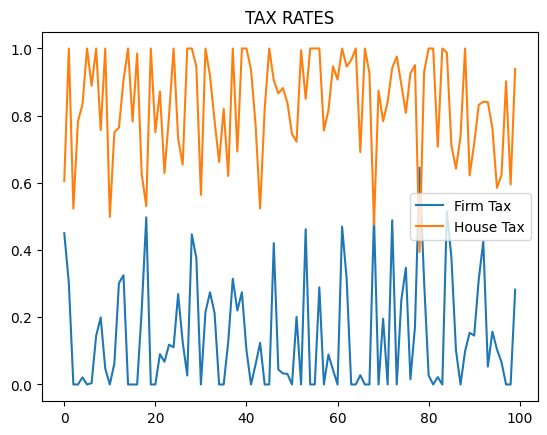

In [187]:
plt.plot(epoch_firmtax,label="Firm Tax")
plt.plot(epoch_housetax,label="House Tax")
plt.legend()
plt.title("TAX RATES")
plt.show()

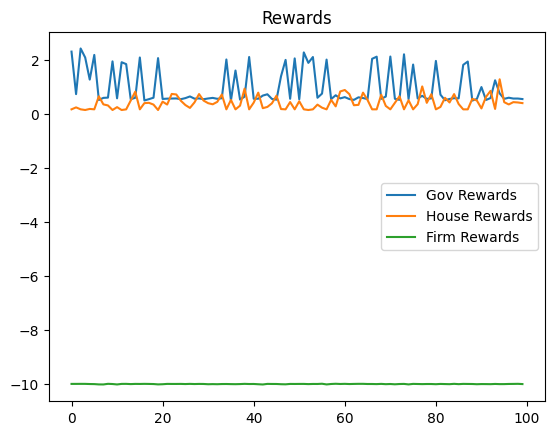

In [188]:
plt.plot(epoch_gov_reward,label="Gov Rewards")
plt.plot(epoch_house_reward,label="House Rewards")
plt.plot(epoch_firm_reward,label="Firm Rewards")
plt.legend()
plt.title("Rewards")
plt.show()

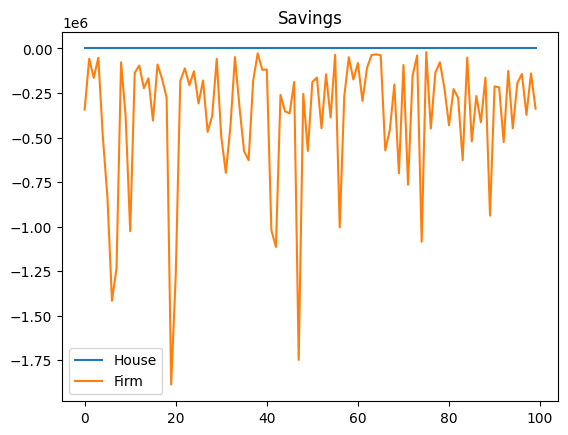

In [189]:
plt.plot(epoch_housesavings,label="House")
plt.plot(epoch_firmsavings,label="Firm")
plt.legend()
plt.title("Savings")
plt.show()

## GA graphs may or may not work

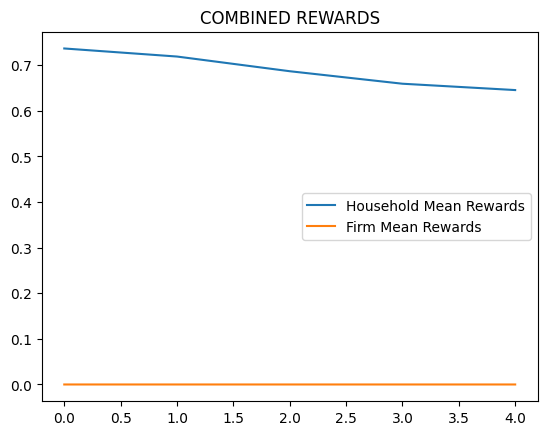

In [190]:
#Both being compared
plt.plot(house_rewards,label="Household Mean Rewards")
plt.plot(firm_rewards,label="Firm Mean Rewards")
plt.legend()
plt.title("COMBINED REWARDS")
plt.show()

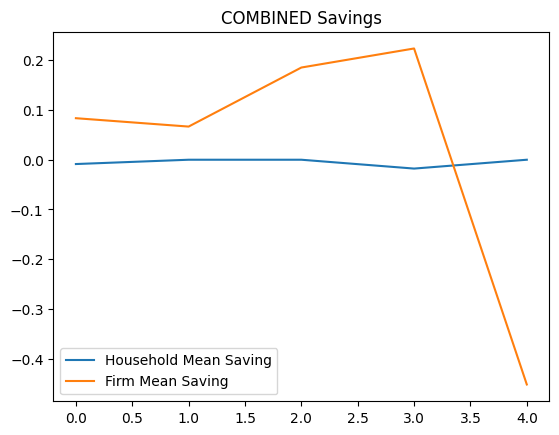

In [191]:
plt.plot(mean_household_savings,label="Household Mean Saving")
plt.plot(mean_firm_savings,label="Firm Mean Saving")
plt.legend()
plt.title("COMBINED Savings")
plt.show()

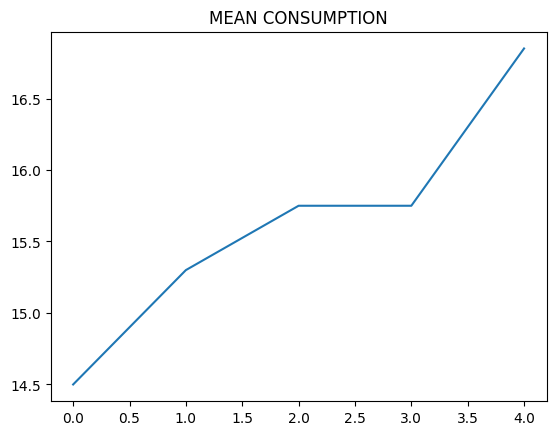

In [192]:
plt.plot(mean_consumption)
plt.title("MEAN CONSUMPTION")
plt.show()

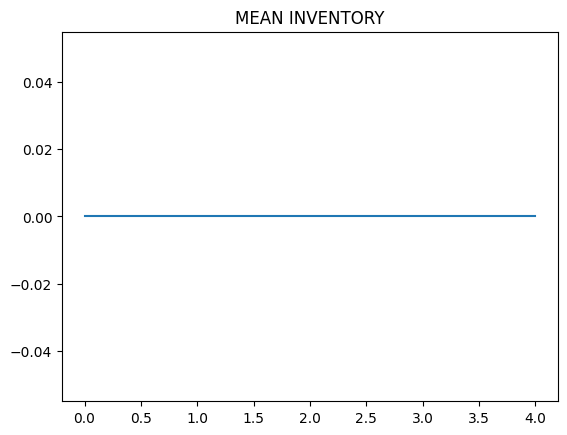

In [193]:
plt.plot(mean_inventory)
plt.title("MEAN INVENTORY")
plt.show()

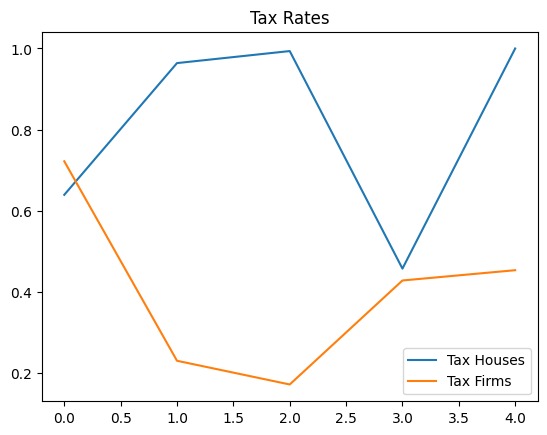

In [194]:
#Both being compared
plt.plot(tax_rates_houses,label="Tax Houses")
plt.plot(tax_rates_firms,label="Tax Firms")
plt.legend()
plt.title("Tax Rates")
plt.show()